In [1]:
using Plots
default(fmt=:png, dpi=300)

In [2]:
using MySQL
using DataFrames
using Dates
using TimeZones
using Plots.PlotMeasures
using StatsBase, LinearAlgebra
using LaTeXStrings
using JSON
import Base: @kwdef

In [3]:
timestamp(t; target_tz::VariableTimeZone=tz"America/Los_Angeles") = astimezone(
    ZonedDateTime(Dates.unix2datetime(t), tz"GMT"), target_tz
)

timestamp (generic function with 1 method)

In [4]:
function get_emeter_data(conn::MySQL.Connection, name::String, idx::Int64)
    DBInterface.execute(
        DBInterface.prepare(conn,
            "SET @v1 := (SELECT emeter_start FROM $(name) WHERE idx = $(idx))"
        )
    )
    DBInterface.execute(
        DBInterface.prepare(conn,
            "SET @v2 := (SELECT emeter_end FROM $(name) WHERE idx = $(idx))"
        )
    )
    events = DBInterface.execute(
        DBInterface.prepare(conn,
            "SELECT * FROM $(name)_emeter WHERE idx BETWEEN @v1 and @v2"
        )
    ) |> DataFrame
    events = transform(
        events,
        :t => (x->timestamp.(x)) => :timestamp
    )
    return events
end

@kwdef mutable struct DBCredentials
    host::String
    name::String
    username::String
    password::String
end

DBCredentials

In [5]:
db_credenitals = DBCredentials(
    ;JSON.parsefile(
        joinpath("db.json"),
        dicttype=Dict{Symbol,String}
    )...
)
# db_credenitals.host = "127.0.0.1";

In [6]:
db_conn = DBInterface.connect(
    MySQL.Connection, db_credenitals.host,
    db_credenitals.username, db_credenitals.password,
    db=db_credenitals.name
)

MySQL.Connection(host="45.33.40.165", user="ccs", port="3306", db="coffee")

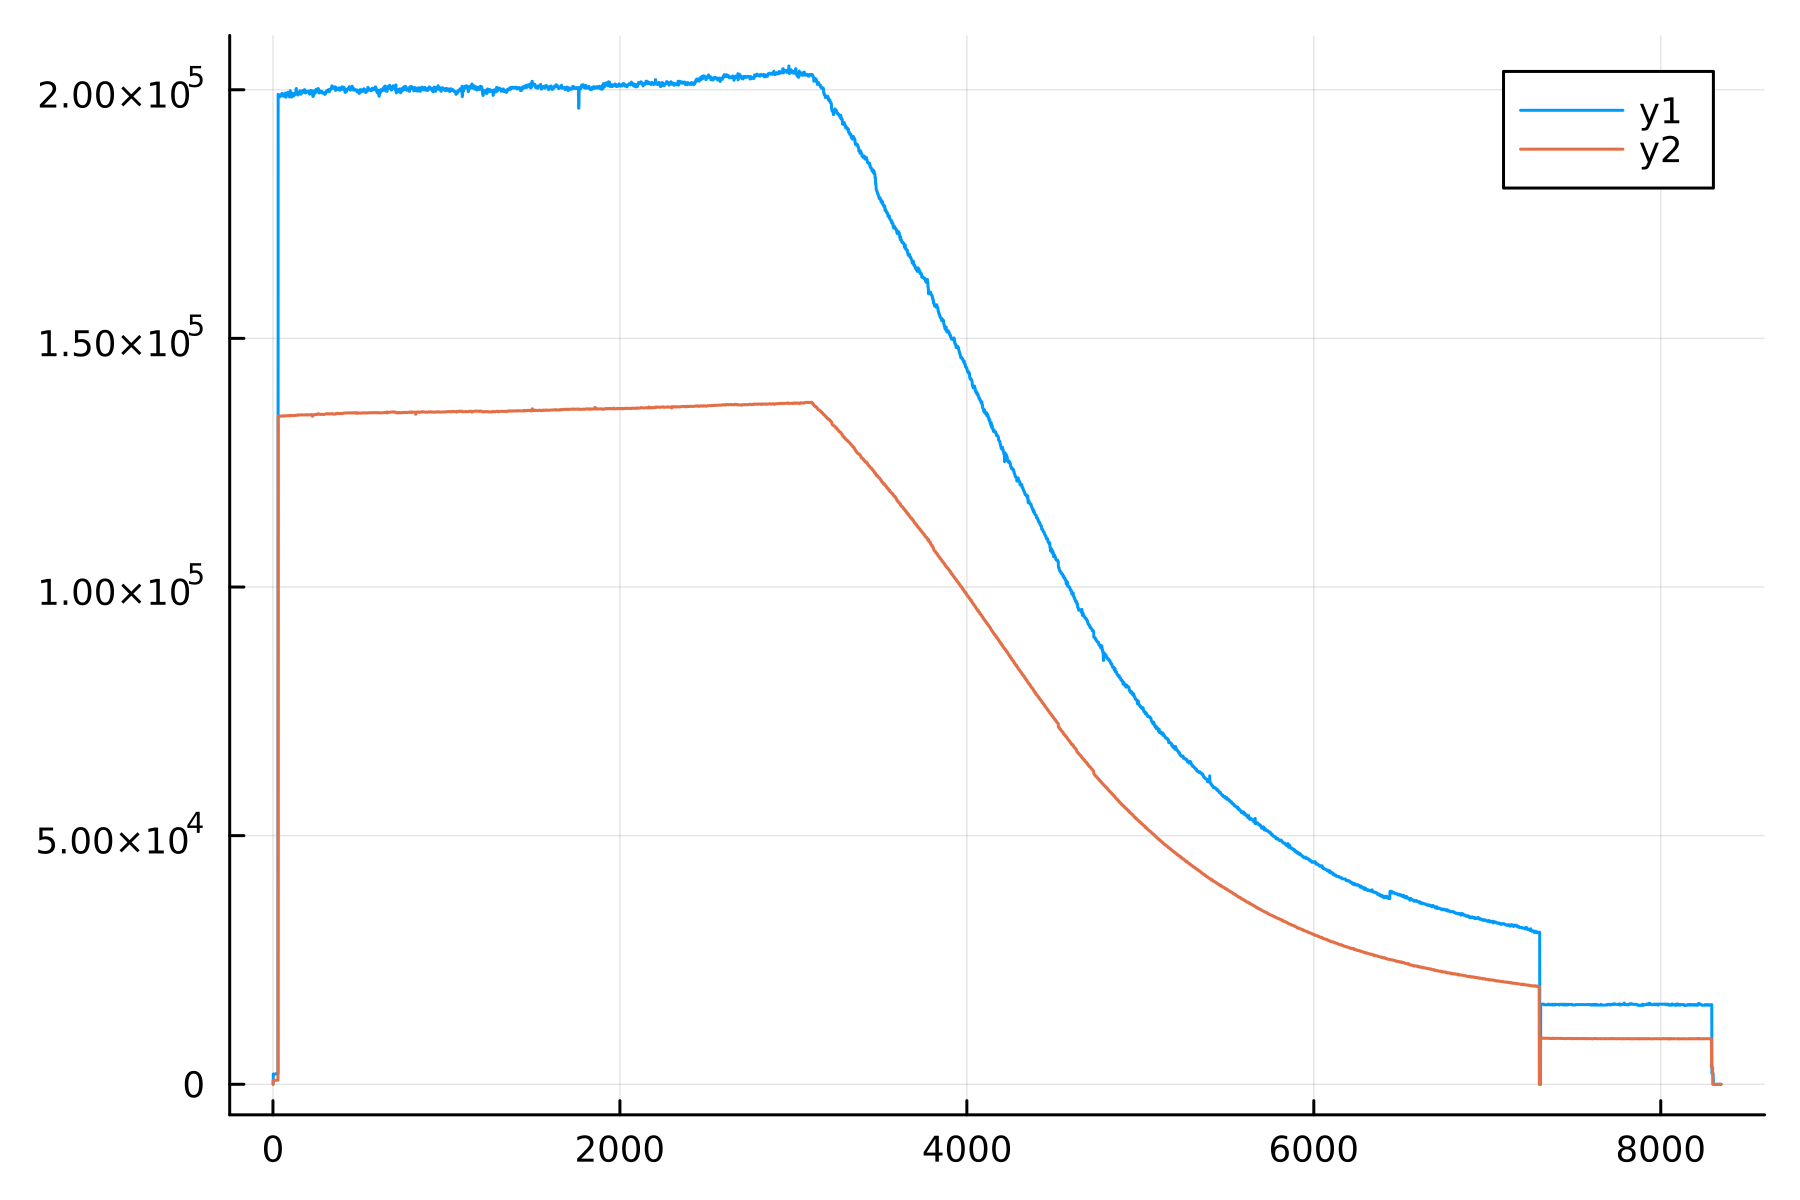

In [7]:
idx = 51
name = "Arstotzka_Ministry_of_Energy"

emeter_data = get_emeter_data(db_conn, name, idx)
plot(emeter_data[!, :ma].* emeter_data[!, :mv] ./ 1000)
plot!(emeter_data[!, :mw])

In [8]:
# https://github.com/JuliaNLSolvers/LsqFit.jl
using LsqFit

# a two-parameter exponential model
# x: array of independent variables
# p: array of model parameters
# model(x, p) will accept the full data set as the first argument `x`.
# This means that we need to write our model function so it applies
# the model to the full dataset. We use `@.` to apply the calculations
# across all rows.
step(x) = @. 0.5*(sign(x)+1)
ramp(x) = @. step(x)*x
model(x, p) = @. p[1] + p[2]*exp(-ramp(x-p[3])*p[4])

model (generic function with 1 method)

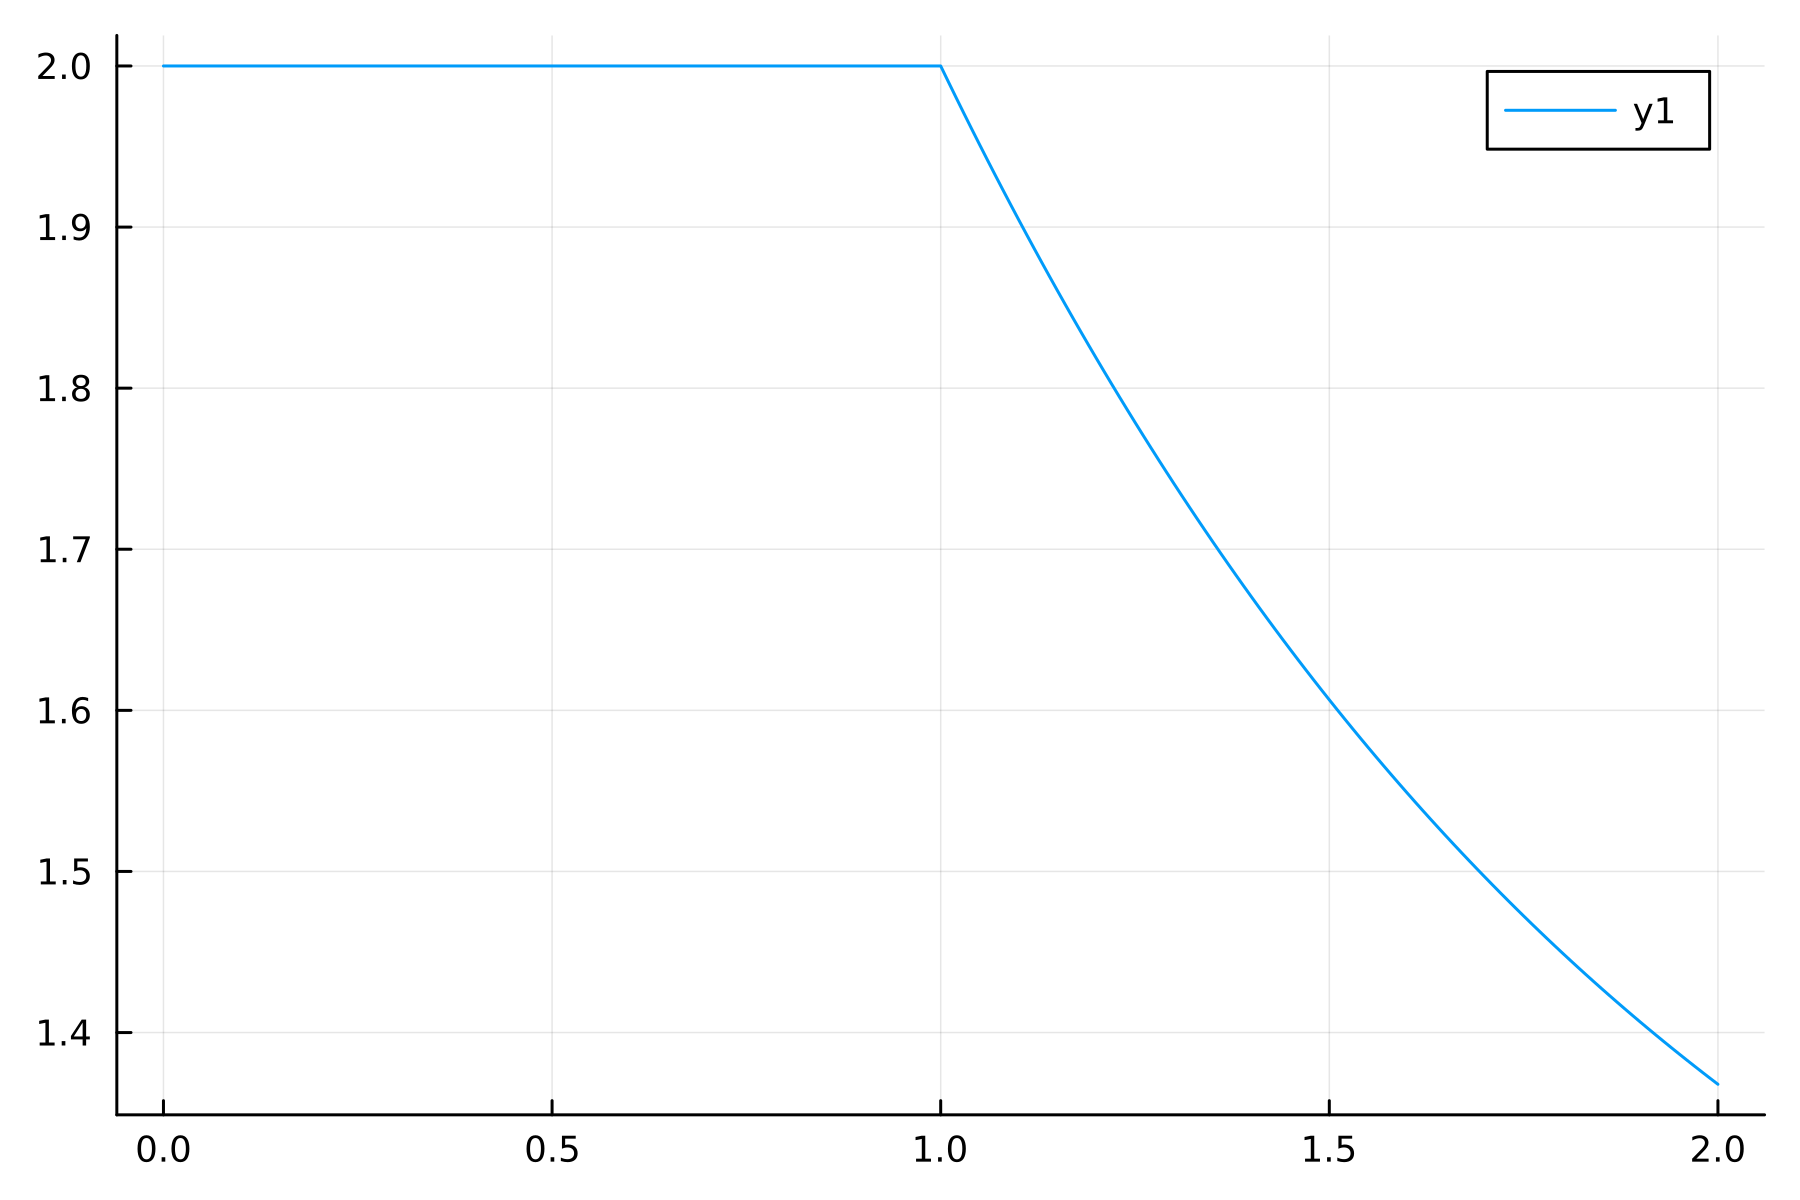

In [9]:
x = collect(0:0.01:2)
y = model(x, [1, 1, 1, 1])
plot(x, y)

In [10]:
y = emeter_data[!, :ma].* emeter_data[!, :mv] ./ 1000
x = collect(0:length(y)-1)
fit = curve_fit(model, x, y, [10000, 100000, 2000, 0.001])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([927.105825245848, 197904.27831578042, 3346.292815787589, 0.0005570797678324379], [198831.38414102627, 196772.14014102626, 196772.14014102626, 196772.14014102626, 196772.14014102626, 196772.14014102626, 196772.14014102626, 196771.47714102626, 196771.47714102626, 196771.47714102626  …  13195.230289990415, 13188.397869340208, 13181.569253833326, 13174.744441350593, 13167.923429774011, 13161.106216986764, 13154.292800873212, 13147.48317931889, 13140.677350210517, 13133.875311435984], [1.0000000002607141 0.9999999999987903 0.0 0.0; 1.0000000002607141 0.9999999999987903 0.0 0.0; … ; 0.9999999999367072 0.061714540124690305 6.803933589680288 -6.107361037202033e7; 0.9999999999367072 0.06168016977725872 6.800144311529326 -6.105180933973162e7], true, Float64[])

In [11]:
fit.param

4-element Vector{Float64}:
    927.105825245848
 197904.27831578042
   3346.292815787589
      0.0005570797678324379

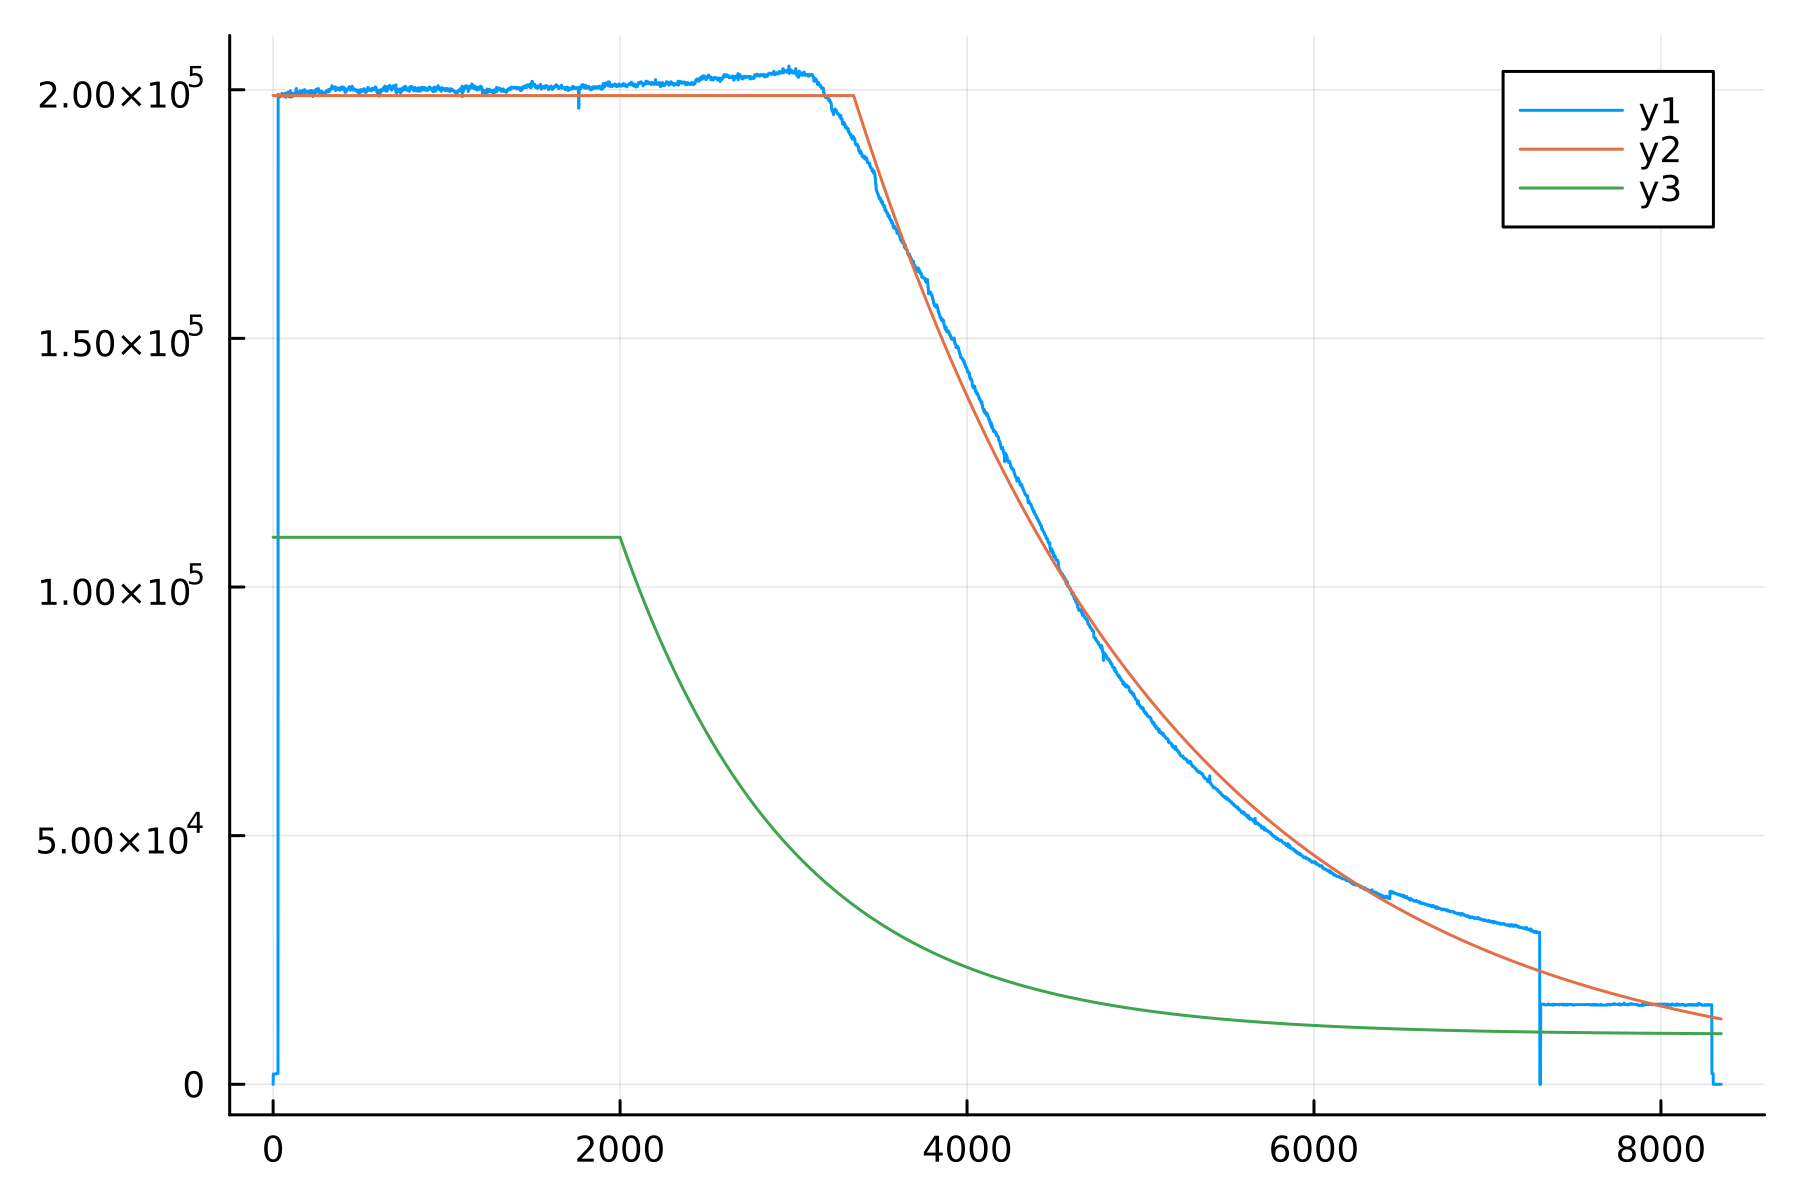

In [12]:
plot(x, y)
plot!(x, model(x, fit.param))
plot!(x, model(x, [10000, 100000, 2000, 0.001]))

In [13]:
8000/60/60

2.2222222222222223

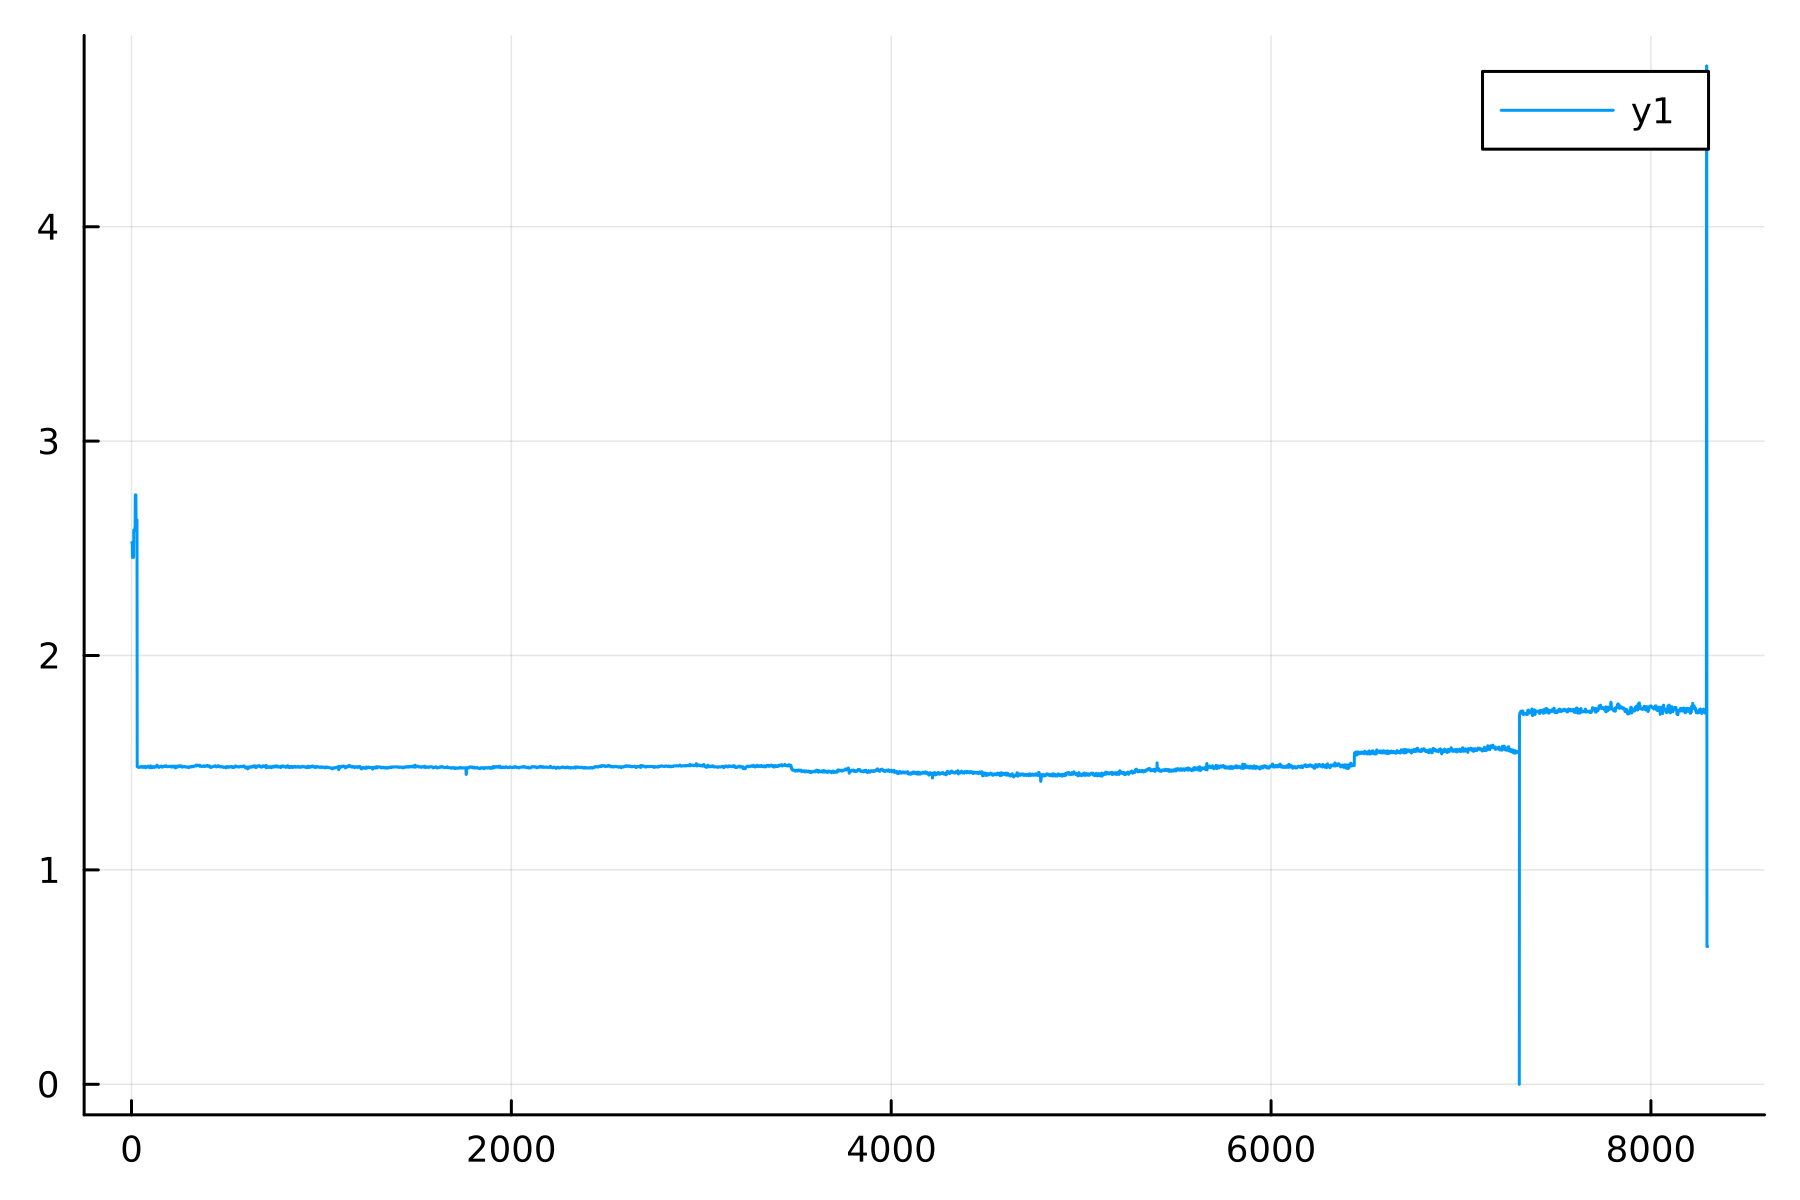

In [14]:
plot(emeter_data[!, :ma].* emeter_data[!, :mv] ./ 1000 ./ emeter_data[!, :mw])